In [98]:
!pip install prophet

In [101]:
# Import required dependencies
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from IPython.display import clear_output
import numpy as np
import time
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

In [77]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/1_ODNIn5n1k9RSVr_7gV2On4idZ6v0B2XPeMhCD18kio/pub?gid=1188863554&single=true&output=csv')
    #df.head()

chiefs = df['chief'].unique()
x = 0
for chief in chiefs:
    #print(chief)
    df.loc[df['chief'] == chief, 'chief_term'] = x
    #dfcoyp['chief_term'] = x
    x = x + 1


In [78]:
df.dtypes

caseId                       object
docketId                     object
caseIssuesId                 object
voteId                       object
dateDecision                 object
decisionType                  int64
usCite                       object
sctCite                      object
ledCite                      object
lexisCite                    object
term                          int64
naturalCourt                  int64
chief                        object
docket                       object
caseName                     object
dateArgument                 object
dateRearg                    object
petitioner                  float64
petitionerState             float64
respondent                  float64
respondentState             float64
jurisdiction                float64
adminAction                 float64
adminActionState            float64
threeJudgeFdc               float64
caseOrigin                  float64
caseOriginState             float64
caseSource                  

In [79]:
#change decision date to DT
df['dateDecision'] = pd.to_datetime(df['dateDecision'], errors='coerce')

In [83]:
df['yearDecision'] = df['dateDecision'].dt.year
case_disposition_over_time = df.groupby('yearDecision')['caseDisposition'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
case_disposition_counts = df.groupby('yearDecision')['caseDisposition'].value_counts()
case_disposition_counts_df = pd.DataFrame(case_disposition_counts)
case_disposition_counts_df.head()

count
yearDecision caseDisposition       
1946         2.0                 27
             3.0                 14
             4.0                  5
             5.0                  2
             7.0                  1

In [84]:
chief_counts = df.groupby('chief_term')['caseDisposition'].value_counts()
chief_counts_df = pd.DataFrame(chief_counts)
chief_counts_df.head()

count
chief_term caseDisposition       
0.0        2.0                654
           3.0                374
           4.0                241
           5.0                 73
           9.0                 45

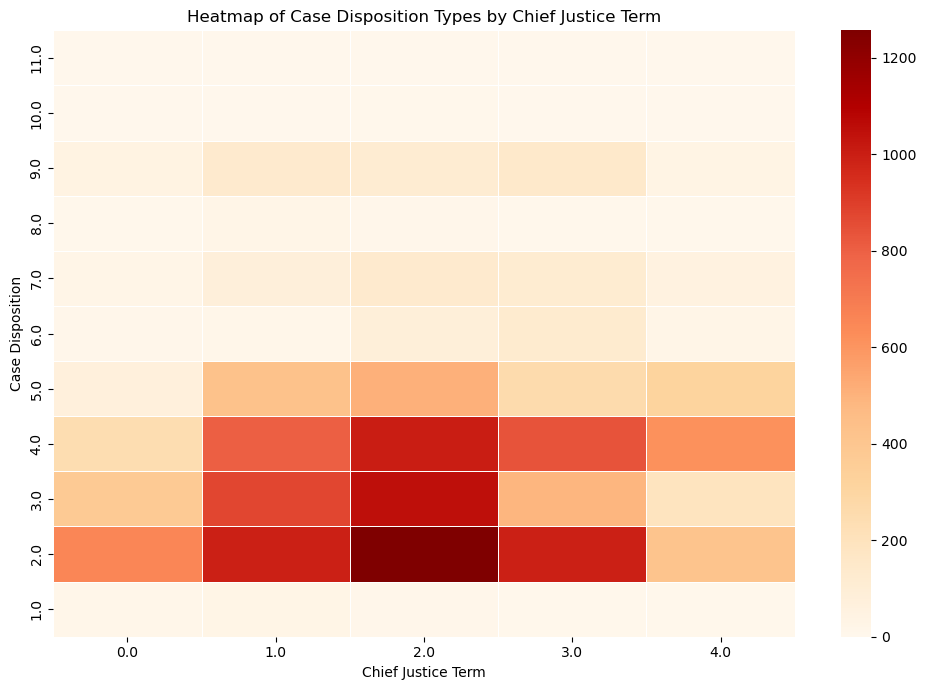

In [85]:
# Pivot the DataFrame to get counts for each disposition per year
pivot_df2 = chief_counts_df.pivot_table(index='caseDisposition', columns='chief_term', values='count', fill_value=0)
pivot_df2 = pivot_df2.sort_index(ascending=False)
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_df2, annot=False, cmap='OrRd', cbar=True, linewidths=.5)

# Customize the plot
plt.title('Heatmap of Case Disposition Types by Chief Justice Term')
plt.xlabel('Chief Justice Term')
plt.ylabel('Case Disposition')
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

In [86]:
chief_counts_dd = df.groupby('chief_term')['decisionDirection'].value_counts()
chief_counts_dd_df = pd.DataFrame(chief_counts_dd)
chief_counts_dd_df.head()

count
chief_term decisionDirection       
0.0        1.0                  732
           2.0                  669
           3.0                   22
1.0        2.0                 2194
           1.0                 1182

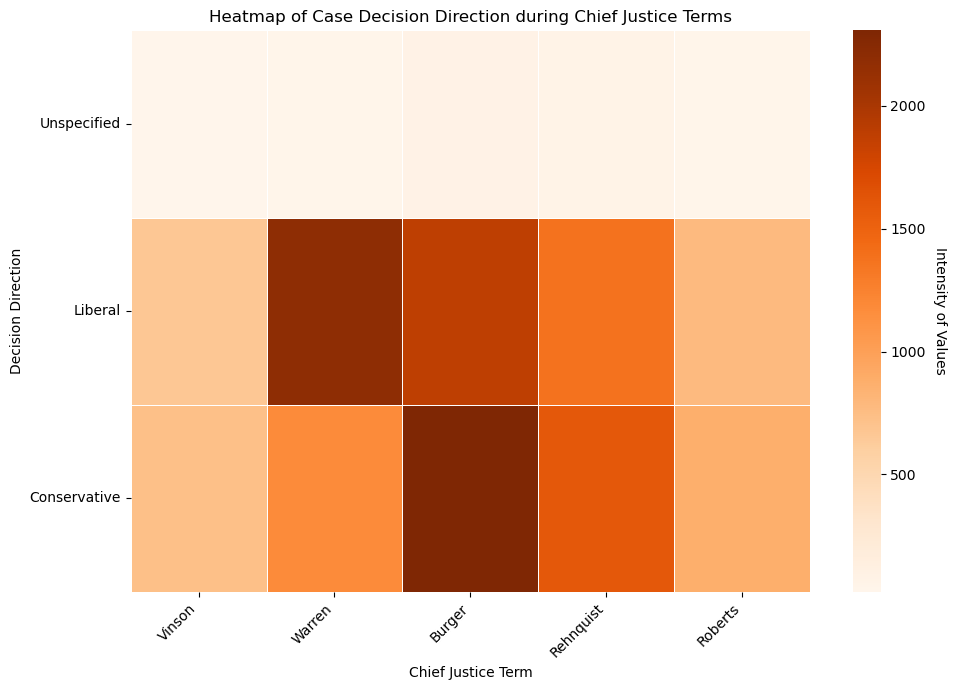

In [87]:
# Pivot the DataFrame to get counts for each direction per term
pivot_dd_index = chief_counts_dd_df.pivot_table(index='decisionDirection', columns='chief_term', values='count', fill_value=0)
pivot_dd = pivot_dd_index.sort_index(ascending=False)

# Create a figure and axis for the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(pivot_dd, cmap="Oranges", cbar=True, linewidths=.5)

# Set custom x-tick and y-tick positions and labels
ax.set_xticks(np.arange(pivot_dd.shape[1]) + 0.5)
ax.set_yticks(np.arange(pivot_dd.shape[0]) + 0.5)

# Set custom tick labels
ax.set_xticklabels(['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts'] * (pivot_dd.shape[1] // 5), rotation=45, ha='right')
ax.set_yticklabels(["Unspecified", "Liberal", "Conservative"], rotation=0)

# Customize the color bar (legend)
colorbar = ax.collections[0].colorbar
colorbar.set_label('Intensity of Values', rotation=270, labelpad=15)

# Customize the plot
plt.title('Heatmap of Case Decision Direction during Chief Justice Terms')
plt.xlabel('Chief Justice Term')
plt.ylabel('Decision Direction')
plt.tight_layout()  # Adjust layout to fit labels

# Show the plot
plt.show()

In [88]:
case_disposition_over_time_df = pd.DataFrame(case_disposition_over_time)
case_disposition_over_time_df.head()

,caseDisposition
yearDecision,
1946,2.0
1947,2.0
1948,2.0
1949,2.0
1950,2.0


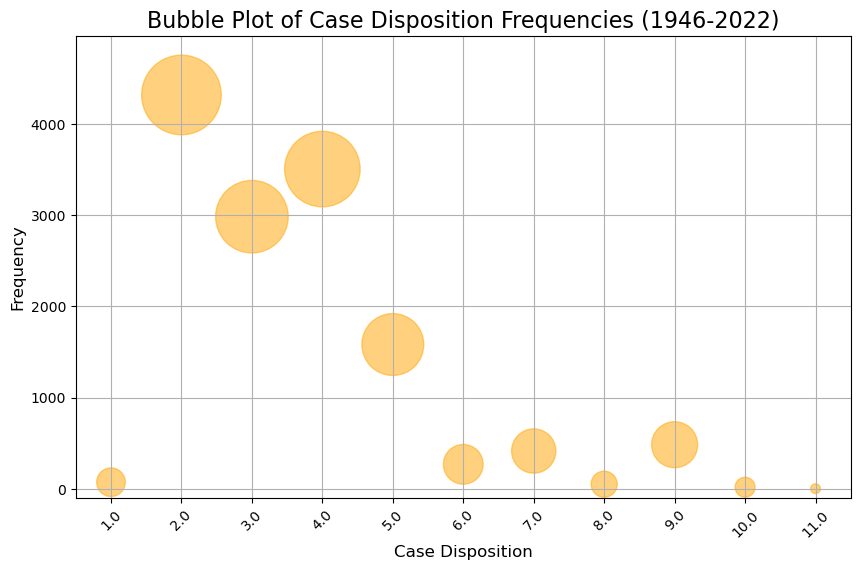

In [89]:
# Assuming dfwork has a 'caseDisposition' column

# Calculate the frequency of each caseDisposition
case_disposition_counts = df['caseDisposition'].value_counts()

# Get the unique caseDisposition values and their frequencies
case_disposition_values = case_disposition_counts.index
frequencies = case_disposition_counts.values

# Normalize bubble sizes for better visualization
bubble_sizes = np.sqrt(frequencies) * 50  # Adjust the scaling factor (50) as needed

# Create the bubble plot
plt.figure(figsize=(10, 6))
plt.scatter(
    case_disposition_values,  # x-axis (caseDisposition)
    frequencies,  # y-axis (frequency of caseDisposition)
    s=bubble_sizes,  # Bubble size (proportional to frequency)
    color='orange', alpha=0.5
)

# Set the title and labels
plt.title('Bubble Plot of Case Disposition Frequencies (1946-2022)', fontsize=16)
plt.xlabel('Case Disposition', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

x_ticks = case_disposition_values  # Use caseDisposition values as tick positions
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)  # Rotate labels if needed for readability

plt.ylim(-100, max(frequencies) * 1.15)  # Set y-limit slightly above the max frequency for better visibility


# Show the plot
plt.grid(True)
plt.show()

In [90]:
#creating dataframe for using in projection modeling
dd_by_date_df = pd.DataFrame(df[['dateDecision','decisionDirection']])
dd_by_date_df.tail()

,dateDecision,decisionDirection
13849,2023-06-22,2.0
13850,2023-06-22,2.0
13851,2023-05-25,1.0
13852,2023-05-22,1.0
13853,2023-06-23,1.0


In [91]:
dd_by_date_df.columns = ["ds", "y"]
dd_by_date_df.tail()

,ds,y
13849,2023-06-22,2.0
13850,2023-06-22,2.0
13851,2023-05-25,1.0
13852,2023-05-22,1.0
13853,2023-06-23,1.0


In [92]:
forecasting_period = 10
forecasting_frequency = 'Y' #for year

In [ ]:
# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(dd_by_date_df)

# Create a future dataframe for prediction
future = model.make_future_dataframe(periods=forecasting_period, freq=forecasting_frequency)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.show()


In [ ]:
# Plot the forecast
fig = model.plot(forecast)

# Access the axes
ax = fig.gca()

# Customize the x-axis and y-axis labels
ax.set_xlabel('Term Year', fontsize=12, labelpad=15)  # Set x-axis label
ax.set_ylabel('Direction of Decision', fontsize=12, labelpad=15)  # Set y-axis label

# Customize the title
ax.set_title('Forecast of Supreme Court Decision Direction', fontsize=14, pad=20)  # Set plot title

# Customize x-ticks and y-ticks
ax.tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability
ax.tick_params(axis='y', labelsize=10)  # Adjust y-tick label size

# Optionally, you can customize the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optionally, set custom x-tick labels
# Example: Replace with your desired labels
new_labels = [' ', ' ', 'Conservative', '', 'Liberal', '', 'Unspecified']  # Example new labels
ax.set_yticklabels(new_labels, rotation=45, fontsize=10)  # Set new y-tick labels and customize

# Show the plot
plt.show()

In [ ]:
fig = model.plot_components(forecast)
for ax in fig.axes:
    if ax.get_ylabel() == 'Trend' or ax.get_ylabel() == 'Seasonality':
        # Get the current y-ticks and set them to whole numbers
        y_ticks = np.arange(ax.get_yticks().min(), ax.get_yticks().max() + 1, 1)
        ax.set_yticks(y_ticks)

# Show the plot
plt.show()

In [96]:
dfwork = df[[
#"issueArea",
"decisionDirection",
"decisionType",
"threeJudgeFdc",
"certReason",
#"lcDisposition",
"lcDispositionDirection",
"partyWinning",
"majVotes",
#"chief_term",
"minVotes",
"caseDisposition"
]]

In [97]:
dfwork.corr()

,decisionDirection,decisionType,threeJudgeFdc,certReason,lcDispositionDirection,partyWinning,majVotes,minVotes,caseDisposition
decisionDirection,1.000000,-0.011150,0.005293,-0.040393,-0.108235,0.094781,0.107861,-0.121406,-0.026995
decisionType,-0.011150,1.000000,0.016891,0.060066,-0.055781,-0.067473,-0.059417,0.048407,0.176855
threeJudgeFdc,0.005293,0.016891,1.000000,-0.396706,0.110311,-0.015379,-0.026838,0.029615,0.010898
certReason,-0.040393,0.060066,-0.396706,1.000000,-0.091611,0.098374,-0.033025,0.022940,0.055383
lcDispositionDirection,-0.108235,-0.055781,0.110311,-0.091611,1.000000,0.008648,-0.037116,0.052694,-0.034858
partyWinning,0.094781,-0.067473,-0.015379,0.098374,0.008648,1.000000,0.094350,-0.093165,0.296629
majVotes,0.107861,-0.059417,-0.026838,-0.033025,-0.037116,0.094350,1.000000,-0.931409,0.108946
minVotes,-0.121406,0.048407,0.029615,0.022940,0.052694,-0.093165,-0.931409,1.000000,-0.109767
caseDisposition,-0.026995,0.176855,0.010898,0.055383,-0.034858,0.296629,0.108946,-0.109767,1.000000


In [68]:
#model_score = []
#model_scores = pd.DataFrame()


def run_model(target):
    dfwork = df[[
    #"issueArea",
    "decisionDirection",
    "decisionType",
    "threeJudgeFdc",
    "certReason",
    #"lcDisposition",
    "lcDispositionDirection",
    "partyWinning",
    "majVotes",
    #"chief_term",
    "minVotes",
    "caseDisposition"
    ]]

    y=df[[target]]
    X = dfwork.drop(columns=y)
    dfwork= dfwork.sort_index(axis=1)
    columns_to_move = ['majVotes', 'minVotes']
    remaining_columns = [col for col in dfwork.columns if col not in columns_to_move]
    dfwork = dfwork[remaining_columns + columns_to_move]

    #reading csv file from link

    #from sklearn.impute import SimpleImputer

    # Impute missing values with the mean
    imputery = SimpleImputer(strategy='constant', fill_value=0)
    #caseDisposition = df[['caseDisposition']]
    y_imputed = imputery.fit_transform(y).reshape(-1)
    #y_imputed = y_imputed.reshape(-1)
    #print(y_imputed)

    #from sklearn.impute import SimpleImputer

    # Impute missing values with the mean
    imputerx = SimpleImputer(strategy='most_frequent')
    X_imputed = pd.DataFrame(imputerx.fit_transform(X), columns=X.columns)
    #print(X_imputed)
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, random_state=42)

    return X_train, X_test, y_train, y_test, target

def models(X_train, X_test, y_train, y_test, target):
    knn(X_train, X_test, y_train, y_test, target)
    lr(X_train, X_test, y_train, y_test, target)
    rf(X_train, X_test, y_train, y_test, target)
    dt(X_train, X_test, y_train, y_test, target)
    #return X_train, X_test, y_train, y_test, target
    #return rt_model

#    return X_train, X_test, y_train, y_test, target
    
    # Create the KNN model with 9 neighbors


def knn(X, xt,y, yt, target):
    model = KNeighborsClassifier(n_neighbors=10)
    model_name = 'KNN'
    function_name = 'knn'
    # Fit the model to the training data
    model.fit(X, y)

    #using score function to find training and testing score
    train_score = model.score(X, y)
    test_score = model.score(xt, yt)
    predictions = model.predict(xt)
    acc_score = accuracy_score(yt, predictions)
    #display(f"{model_name} Train/Test Score for {target} column : {train_score:.3f}/{test_score:.3f}")
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    #return knn_train_score, knn_test_score, target
    return model

def lr(X, xt,y, yt, target):
    # Create the logistic regression classifier model with a random_state of 1
    model = LogisticRegression(max_iter=2000)
    model_name = 'Logistic Regression'
    function_name = 'lr'
    # Fit the model to the training data
    model.fit(X, y)

    train_score = model.score(X, y)
    test_score = model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")

    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return model

def rf(X, xt,y, yt, target):
    # Create the logistic regression classifier model with a random_state of 1
    rt_model = RandomForestClassifier(n_estimators=128, random_state=42)
    model_name = 'Random Forest'
    function_name = 'rf'
    # Fit the model to the training data
    rt_model.fit(X, y)
    
    train_score = rt_model.score(X, y)
    test_score = rt_model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = rt_model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")
    #trained_model = model
    #print({trained_model})
    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return rt_model

def dt(X, xt,y, yt, target):
    from sklearn import tree
    # Create the logistic regression classifier model with a random_state of 1
    model = tree.DecisionTreeClassifier()
    model_name = 'Decision Tree'
    function_name = 'dt'
    # Fit the model to the training data
    model.fit(X, y)

    train_score = model.score(X, y)
    test_score = model.score(xt, yt)

    # Validate the model by checking the model accuracy with model.score

    #display(f"{model} Train/Test Score for {target} column : {lr_train_score:.3f}/{lr_test_score:.3f}")
    predictions = model.predict(xt)
    # Calculate the accuracy score
    acc_score = accuracy_score(yt, predictions)
    #print(f"Accuracy Score : {acc_score}")

    update_score(target,model_name, function_name, train_score, test_score, acc_score)
    return model

def update_score(target, model, fn, trs, tss, acc):
    
    model_score.append({'target_column': target, 'model_name': model, 'function_name' : fn, 'training_score': trs, 'testing_score': tss, 'accuracy_score': acc})
    #display(model_scores.head())
    #return model_scores    

def predict_outcome(trained_model):
    #    #prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
#    prompts = prompts.sort_values(by = ['features', 'selection'])
#    prompts.reset_index(drop=True, inplace=True)
#    prompts
    #selection_prompts = prompts
    selection1 = np.array([])
    for p in prompts['features'].unique():
        #time.sleep(1)
        display(f"Please select a feature from the list of {p} below:")
        
        for i, feature in enumerate((prompts[prompts['features'] == p]['value']), start=1):
            display(f"{i}... {feature}")
        selection1 = np.append(selection1,int(input("Enter the number corresponding to your choice: "))).astype(int)
        
        clear_output()
        
        #time.sleep(1)

    mv = np.append(selection1,int(input("Enter number of majority votes: "))).astype(int)
    nv = np.append(selection1,int(input("Enter number of minority votes: "))).astype(int)
    #selection_df = pd.DataFrame(selection1)
    #selection_df = selection_df.T
    #selection_df.loc[0]
    #predict(selection1)
    #return selection1
    selection_df = pd.DataFrame(selection1)
    selection_df = selection_df.T
    selection_df.loc[0]
    #print(selection_df)
    #X_new1 = np.array([X_imputed2.iloc[13853].to_numpy().astype(int)])
    X_new1 = np.array([selection_df.iloc[0].to_numpy().astype(int)])
    #print(X_new1)
    
    # Get prediction
    #print(model)
    #global trained_model
    #prediction = trained_model.predict(X_new1)
    prediction = trained_model.predict(X_new1)
    #print(f"Based on the data, prediction for the {y.columns[0]} is {prediction[0][0].astype(int)}")
    #print(f"Based on the data, prediction for the {y.columns[1]} is {prediction[0][1].astype(int)}")
    #my_prediction = prompts[(prompts['features'] == y_imputed.columns[0]) & (prompts['selection'] == round(prediction[0][0],0))]['value']
    my_prediction = prompts[(prompts['features'] == target) & (prompts['selection'] == round(prediction[0]))]['value'].iloc[0]
    clear_output()
    print(f"I predict that {my_prediction}")
#prediction = model.predict(rt_model, selection1)

In [69]:
targets = ('partyWinning', 'decisionDirection', 'decisionType', 'caseDisposition')
model_score = []
for target in targets:

    X_train, X_test, y_train, y_test, target = run_model(target)
    models(X_train, X_test, y_train, y_test, target)

model_scores = pd.DataFrame(model_score)

model_scores

,target_column,model_name,function_name,training_score,testing_score,accuracy_score
0,partyWinning,KNN,knn,0.961983,0.949192,0.949192
1,partyWinning,Logistic Regression,lr,0.778441,0.771940,0.771940
2,partyWinning,Random Forest,rf,0.985274,0.967090,0.967090
3,partyWinning,Decision Tree,dt,0.985274,0.969400,0.969400
4,decisionDirection,KNN,knn,0.904042,0.890589,0.890589
5,decisionDirection,Logistic Regression,lr,0.634552,0.629330,0.629330
6,decisionDirection,Random Forest,rf,0.941193,0.924365,0.924365
7,decisionDirection,Decision Tree,dt,0.941193,0.913684,0.913684
8,decisionType,KNN,knn,0.843407,0.834873,0.834873
9,decisionType,Logistic Regression,lr,0.830606,0.834007,0.834007


In [ ]:
trained_model = None
prompts=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTcUMWXktcB48qH6B77aGPX1XfrkbBc2_RxzJbmCdtDkUZa2m1orezx1pcrGdvfGytfNQL8L-_58SyP/pub?gid=0&single=true&output=csv")
prompts = prompts.sort_values(by = ['features', 'selection'])
prompts.reset_index(drop=True, inplace=True)

In [71]:
target = 'decisionType'
trained_model = rf(X_train, X_test, y_train, y_test, target)
predict_outcome(trained_model)

I predict that equally divided vote


In [108]:
dfwork.corr()

,caseDisposition,certReason,chief_term,decisionDirection,decisionType,lcDisposition,partyWinning,threeJudgeFdc,majVotes,minVotes
caseDisposition,1.000000,0.055383,0.098774,-0.026995,0.176855,0.095043,0.296629,0.010898,0.108946,-0.109767
certReason,0.055383,1.000000,0.026959,-0.040393,0.060066,-0.004911,0.098374,-0.396706,-0.033025,0.022940
chief_term,0.098774,0.026959,1.000000,-0.066552,-0.037462,-0.031272,0.053325,-0.074783,0.058441,0.005090
decisionDirection,-0.026995,-0.040393,-0.066552,1.000000,-0.011150,0.020459,0.094781,0.005293,0.107861,-0.121406
decisionType,0.176855,0.060066,-0.037462,-0.011150,1.000000,-0.012978,-0.067473,0.016891,-0.059417,0.048407
lcDisposition,0.095043,-0.004911,-0.031272,0.020459,-0.012978,1.000000,0.056618,0.152791,0.038283,-0.057137
partyWinning,0.296629,0.098374,0.053325,0.094781,-0.067473,0.056618,1.000000,-0.015379,0.094350,-0.093165
threeJudgeFdc,0.010898,-0.396706,-0.074783,0.005293,0.016891,0.152791,-0.015379,1.000000,-0.026838,0.029615
majVotes,0.108946,-0.033025,0.058441,0.107861,-0.059417,0.038283,0.094350,-0.026838,1.000000,-0.931409
minVotes,-0.109767,0.022940,0.005090,-0.121406,0.048407,-0.057137,-0.093165,0.029615,-0.931409,1.000000


In [2]:
#set # if nax rows and columns to show
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

partywinning
is disposition direction
Declaration uncon
case disposition
Vote unclear
isdecisiondirection
issuearea
decisiondirectiondissent
lawsupp
case source

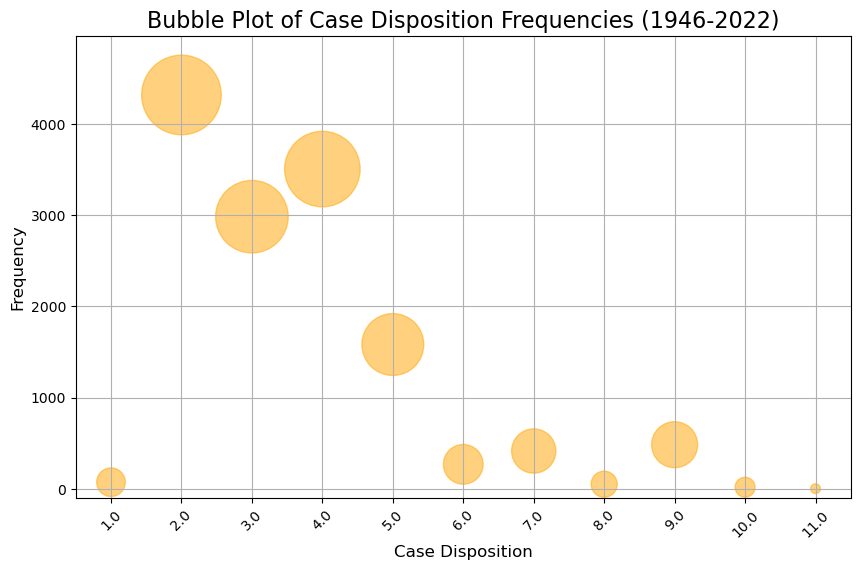

In [ ]:
#!pip install pydotplus
import pydotplus
from IPython.display import Image
#Create DOT data
dot_data = tree.export_graphviz(
    d_model, out_file=None, feature_names=X_imputed.columns, filled=True, max_depth=30
)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())